<a href="https://colab.research.google.com/github/bieri2/ATMS-597-Project-4-Wx-Prediction/blob/master/ATMS597_GroupE_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Helper functions

In [0]:
%matplotlib inline
sns.set_style('whitegrid')

# Define function to plot target vs. predicted values
def plot_predict(time, actual, predicted, colors, legendloc, title, ylabel, ymin, ymax, outfile):
    """
    This function plots predicted vs. target values for a given period in time. 

    Parameters:
    -time (DateTime index): Array of time values corresponding to the input data
    -actual (Series, NumPy array): Array containing target data
    -predicted (Series, NumPy array): Array containing predicted values
    -colors (list): List of strings; desired colors for plot. Format [target, predicted]
    -legendloc (string): String corresponding to possible legend locations, see matplotlib docs for more info
    -title (string): Title of plot
    -ylabel (string): Y-axis label
    -ymin (int or float): Lower limit y-value
    -ymax (int or float): Upper limit y-value
    -outfile (string): Name of file where plot should be saved

    Returns:
    Plots a time series of target and predicted values.

    """
    plt.figure(figsize = (15, 5))
    plt.plot(time, actual, color = colors[0], label = 'Observed')
    plt.plot(time, predicted, color = colors[1], alpha = 0.8, label = 'Predicted')
    # Add dashed vertical line to denote beginning of 2019
    plt.vlines(dt.datetime(2019, 1, 1), ymin, ymax, linestyles = 'dashed', alpha = 0.7)
    plt.legend(loc = legendloc, fontsize = 12)
    plt.title(title, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 14)
    plt.xlabel('Time', fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.xlim(time[0] - pd.Timedelta(days = 1),  time[-1] + pd.Timedelta(days = 1))
    plt.ylim(ymin, ymax)
    plt.savefig(outfile)
    plt.show()

In [0]:
# Define function to apply regression to input dataframes
def reg_predict(x, y, predict, coef = False, regularizer = None):
    """
    This function applies linear regression to the input data.

    Parameters:
    -x (DataFrame, Series, or NumPy array): Array of predictors; training data.
    -y (DataFrame, Series, or NumPy array): Array of predictands; training data.
    -predict (DataFrame, Series, or NumPy array): Application data to which model will be applied.
    -coef (Boolean, default False): True - return coefficients, False - do not return coefficients
    -regularizer: Without or with L2 regularization

    Returns:
    -train (NumPy array): Predicted values using training data.
    -predict (NumPy array): Predicted values using application data.
    -model.coef_ (NumPy array): Model coefficients, only returned if coef = True
    """
    model   = LinearRegression(fit_intercept = True, normalize = True).fit(x, y)
    if regularizer=="Ridge":
      model   = Ridge(fit_intercept = True, normalize = True).fit(x, y)
    train   = model.predict(x)
    predict = model.predict(predict)

    # Return coefficients if user desires
    if coef:
      return train, predict, model.coef_
    else:
      return train, predict

In [0]:
# Define function to compute RMSE for all predicted variables
def calc_rmse(Tmax_actual, Tmax_predicted, Tmin_actual, Tmin_predicted,
              Wmax_actual, Wmax_predicted, Precip_actual, Precip_predicted):
    """
    This function applies the sklearn MSE function to inputs and calculates the square root.
    """
    # Calculate MSE for each variable using sklearn function
    Tmax_rmse   = np.sqrt(mean_squared_error(Tmax_actual, Tmax_predicted))
    Tmin_rmse   = np.sqrt(mean_squared_error(Tmin_actual, Tmin_predicted))
    Wmax_rmse   = np.sqrt(mean_squared_error(Wmax_actual, Wmax_predicted))
    Precip_rmse = np.sqrt(mean_squared_error(Precip_actual, Precip_predicted))

    # Print to user
    print('Tmax error: {0:4.3f}'.format(Tmax_rmse))
    print('Tmin error: {0:4.3f}'.format(Tmin_rmse)) 
    print('Wmax error: {0:4.3f}'.format(Wmax_rmse))
    print('Precip error: {0:4.3f}'.format(Precip_rmse))

    return [Tmax_rmse, Tmin_rmse, Wmax_rmse, Precip_rmse]

## Read and process data

In [0]:
# Define path to data
datapath = "/content/drive/My Drive/ATMS 597 Project 4/"
# Read data from pre-processed files
all_daily_data_nopcp = pd.read_csv(datapath + 'all_data_daily.csv', index_col = 'Timestamp').drop(columns='RTOTOBS') # Drop precip observations
all_daily_data = pd.read_csv(datapath + 'all_data_daily.csv', index_col = 'Timestamp')
all_3hr_data   = pd.read_csv(datapath + 'all_data_3hr.csv', index_col = 'Timestamp')

In [0]:
# Resample 3-hourly data to daily means
all_3hr_to_daily = all_3hr_data.set_index(pd.to_datetime(all_3hr_data.index)).resample('D').mean()

In [0]:
# Join DataFrames
all_daily_data = all_daily_data.join(all_3hr_to_daily)
all_daily_data_nopcp = all_daily_data_nopcp.join(all_3hr_to_daily)

In [0]:
# Drop NaNs
all_daily_data = all_daily_data.dropna()
all_daily_data_nopcp = all_daily_data_nopcp.dropna()

## Prediction via regression

### Simple LR model

In [0]:
# Get predicted values using training data (_pred) and predicted values for 2019 (_pred19) 
# 2019 predictions will be compared to 2019 observations
Tmax_sm_pred, Tmax_sm_pred19     = reg_predict(all_daily_data_nopcp[['TMAXGFS']][:'2018-12-31'], 
                                               all_daily_data_nopcp['TMAXOBS'][:'2018-12-31'], 
                                               all_daily_data_nopcp[['TMAXGFS']]['2019-01-01':])

Tmin_sm_pred, Tmin_sm_pred19     = reg_predict(all_daily_data_nopcp[['TMINGFS']][:'2018-12-31'],
                                               all_daily_data_nopcp['TMINOBS'][:'2018-12-31'], 
                                               all_daily_data_nopcp[['TMINGFS']]['2019-01-01':])

Wmax_sm_pred, Wmax_sm_pred19     = reg_predict(all_daily_data_nopcp[['WMAXGFS']][:'2018-12-31'],
                                               all_daily_data_nopcp['WMAXOBS'][:'2018-12-31'], 
                                               all_daily_data_nopcp[['WMAXGFS']]['2019-01-01':])

Precip_sm_pred, Precip_sm_pred19 = reg_predict(all_daily_data[['RTOTGFS']][:'2018-12-31'],
                                               all_daily_data['RTOTOBS'][:'2018-12-31'], 
                                               all_daily_data[['RTOTGFS']]['2019-01-01':], regularizer="Ridge")

In [0]:
# Calculate RMSE for training period
Tmax_sm_error, Tmin_sm_error, Wmax_sm_error, Precip_sm_error = calc_rmse(all_daily_data_nopcp['TMAXOBS'][:'2018-12-31'], Tmax_sm_pred, 
                                                                         all_daily_data_nopcp['TMINOBS'][:'2018-12-31'], Tmin_sm_pred,
                                                                         all_daily_data_nopcp['WMAXOBS'][:'2018-12-31'], Wmax_sm_pred, 
                                                                         all_daily_data['RTOTOBS'][:'2018-12-31'], Precip_sm_pred)

Tmax error: 2.204
Tmin error: 2.000
Wmax error: 1.669
Precip error: 2.902


In [0]:
# Calculate RMSE for validation period
Tmax_sm_error19, Tmin_sm_error19, Wmax_sm_error19, Precip_sm_error19 = calc_rmse(all_daily_data_nopcp['TMAXOBS']['2019-01-01':], Tmax_sm_pred19, 
                                                                                 all_daily_data_nopcp['TMINOBS']['2019-01-01':], Tmin_sm_pred19,
                                                                                 all_daily_data_nopcp['WMAXOBS']['2019-01-01':], Wmax_sm_pred19, 
                                                                                 all_daily_data['RTOTOBS']['2019-01-01':], Precip_sm_pred19)

Tmax error: 2.135
Tmin error: 1.912
Wmax error: 1.668
Precip error: 1.538


### Simple LR model plots

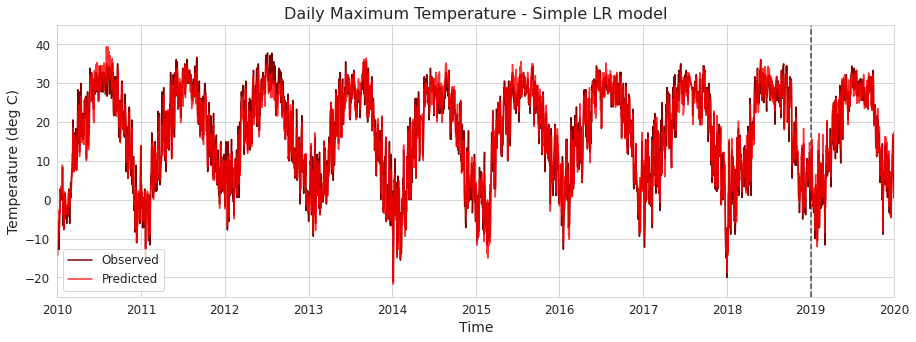

In [0]:
# Plot predicted vs. actual Tmax
Tmax_actual    = all_daily_data_nopcp['TMAXOBS']
Tmax_predicted = np.concatenate((Tmax_sm_pred, Tmax_sm_pred19))
colors = ['maroon', 'red']
plot_predict(pd.to_datetime(all_daily_data_nopcp.index), Tmax_actual, Tmax_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Maximum Temperature - Simple LR model', ylabel = 'Temperature (deg C)', 
             ymin = -25, ymax = 45, outfile = 'TMAX_sm_lr.png')

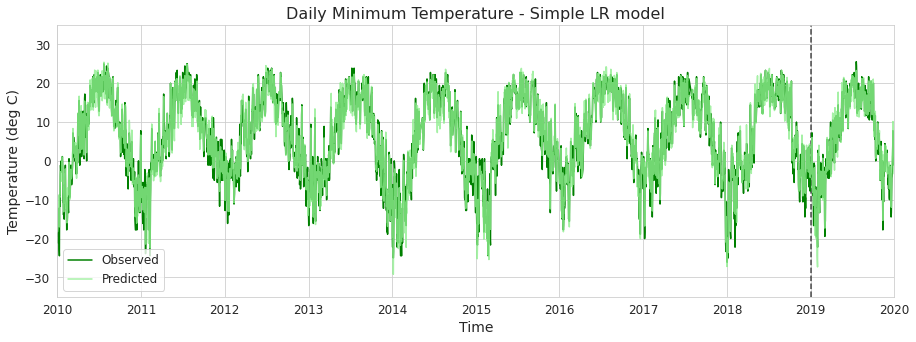

In [0]:
# Plot predicted vs. actual Tmin
Tmin_actual    = all_daily_data_nopcp['TMINOBS']
Tmin_predicted = np.concatenate((Tmin_sm_pred, Tmin_sm_pred19))
colors = ['green', 'lightgreen']
plot_predict(pd.to_datetime(all_daily_data_nopcp.index), Tmin_actual, Tmin_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Minimum Temperature - Simple LR model', ylabel = 'Temperature (deg C)', 
             ymin = -35, ymax = 35, outfile = 'TMIN_sm_lr.png')

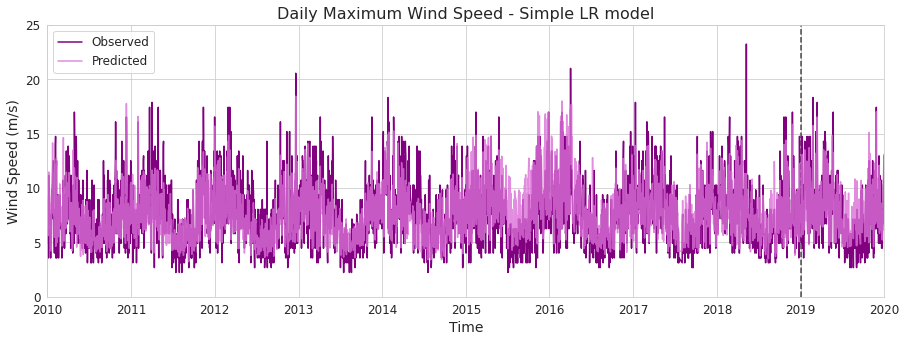

In [0]:
# Plot predicted vs. actual Wmax
Wmax_actual    = all_daily_data_nopcp['WMAXOBS']
Wmax_predicted = np.concatenate((Wmax_sm_pred, Wmax_sm_pred19))
colors = ['purple', 'orchid']
plot_predict(pd.to_datetime(all_daily_data_nopcp.index), Wmax_actual, Wmax_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Maximum Wind Speed - Simple LR model', ylabel = 'Wind Speed (m/s)', 
             ymin = 0, ymax = 25, outfile = 'WMAX_sm_lr.png')

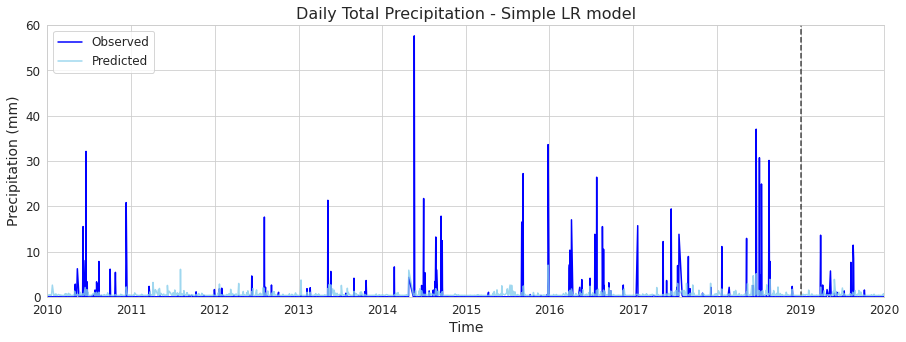

In [0]:
# Plot predicted vs. actual Precip
Precip_actual    = all_daily_data['RTOTOBS']
Precip_predicted = np.concatenate((Precip_sm_pred, Precip_sm_pred19))
colors = ['blue', 'skyblue']
plot_predict(pd.to_datetime(all_daily_data.index), Precip_actual, Precip_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Total Precipitation - Simple LR model', ylabel = 'Precipitation (mm)', 
             ymin = 0, ymax = 60, outfile = 'RTOT_ok_lr.png')

### LR using (almost) all predictors

In [0]:
# Get predicted values using training data (_pred) and predicted values for 2019 (_pred19) 
# 2019 predictions will be compared to 2019 observations
Tmax_all_pred, Tmax_all_pred19, Tmax_coef       = reg_predict(all_daily_data_nopcp[all_daily_data_nopcp.columns.values[3:]][:'2018-12-31'], 
                                                              all_daily_data_nopcp['TMAXOBS'][:'2018-12-31'], 
                                                              all_daily_data_nopcp[all_daily_data_nopcp.columns.values[3:]]['2019-01-01':], coef = True)

Tmin_all_pred, Tmin_all_pred19, Tmin_coef       = reg_predict(all_daily_data_nopcp[all_daily_data_nopcp.columns.values[3:]][:'2018-12-31'],
                                                              all_daily_data_nopcp['TMINOBS'][:'2018-12-31'], 
                                                              all_daily_data_nopcp[all_daily_data_nopcp.columns.values[3:]]['2019-01-01':], coef = True)

Wmax_all_pred, Wmax_all_pred19, Wmax_coef       = reg_predict(all_daily_data_nopcp[all_daily_data_nopcp.columns.values[3:]][:'2018-12-31'],
                                                              all_daily_data_nopcp['WMAXOBS'][:'2018-12-31'], 
                                                              all_daily_data_nopcp[all_daily_data_nopcp.columns.values[3:]]['2019-01-01':], coef = True)

Precip_all_pred, Precip_all_pred19, Precip_coef = reg_predict(all_daily_data[all_daily_data.columns.values[4:]][:'2018-12-31'],
                                                              all_daily_data['RTOTOBS'][:'2018-12-31'], 
                                                              all_daily_data[all_daily_data.columns.values[4:]]['2019-01-01':], coef = True, regularizer="Ridge")

In [0]:
# Calculate RMSE for validation period
Tmax_sm_error19, Tmin_sm_error19, Wmax_sm_error19, Precip_sm_error19 = calc_rmse(all_daily_data_nopcp['TMAXOBS']['2019-01-01':], Tmax_all_pred19, 
                                                                                 all_daily_data_nopcp['TMINOBS']['2019-01-01':], Tmin_all_pred19,
                                                                                 all_daily_data_nopcp['WMAXOBS']['2019-01-01':], Wmax_all_pred19, 
                                                                                 all_daily_data['RTOTOBS']['2019-01-01':], Precip_all_pred19)

Tmax error: 1.905
Tmin error: 1.730
Wmax error: 1.581
Precip error: 1.521


### LR all predictors plots 

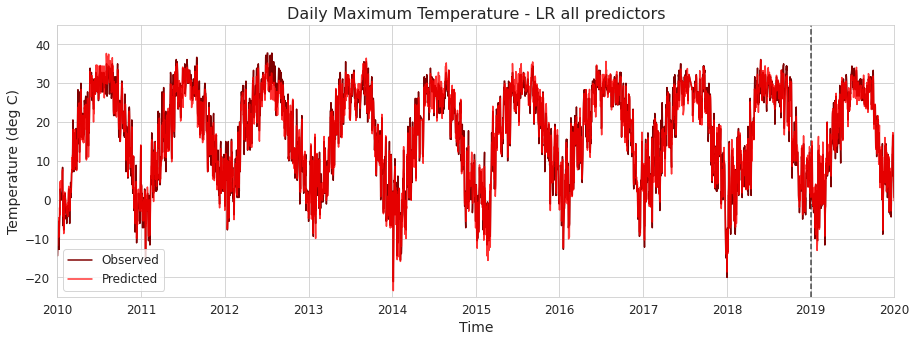

In [0]:
# Plot predicted vs. actual Tmax
Tmax_actual    = all_daily_data_nopcp['TMAXOBS']
Tmax_predicted = np.concatenate((Tmax_all_pred, Tmax_all_pred19))
colors = ['maroon', 'red']
plot_predict(pd.to_datetime(all_daily_data_nopcp.index), Tmax_actual, Tmax_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Maximum Temperature - LR all predictors', ylabel = 'Temperature (deg C)', 
             ymin = -25, ymax = 45, outfile = 'TMAX_all_lr.png')

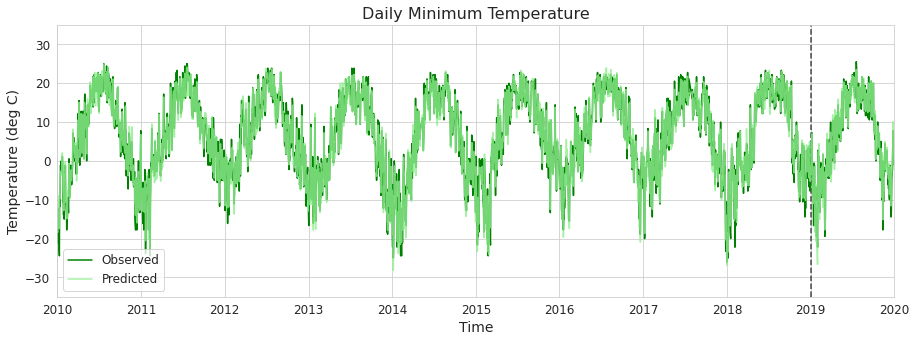

In [0]:
# Plot predicted vs. actual Tmin
Tmin_actual    = all_daily_data_nopcp['TMINOBS']
Tmin_predicted = np.concatenate((Tmin_all_pred, Tmin_all_pred19))
colors = ['green', 'lightgreen']
plot_predict(pd.to_datetime(all_daily_data_nopcp.index), Tmin_actual, Tmin_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Minimum Temperature', ylabel = 'Temperature (deg C)', 
             ymin = -35, ymax = 35, outfile = 'TMIN_all_lr.png')

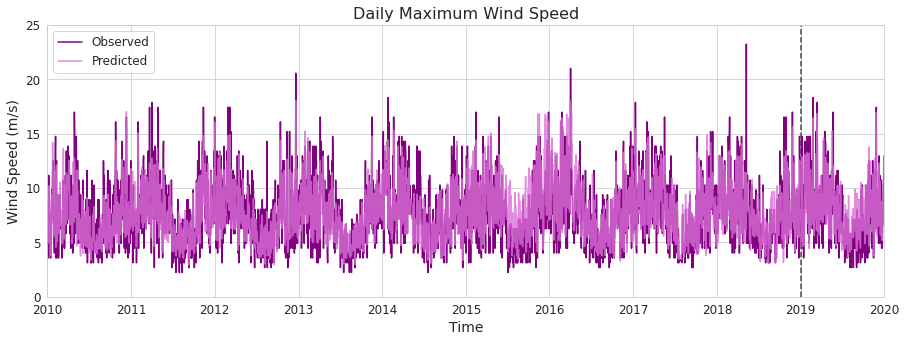

In [0]:
# Plot predicted vs. actual Wmax
Wmax_actual    = all_daily_data_nopcp['WMAXOBS']
Wmax_predicted = np.concatenate((Wmax_all_pred, Wmax_all_pred19))
colors = ['purple', 'orchid']
plot_predict(pd.to_datetime(all_daily_data_nopcp.index), Wmax_actual, Wmax_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Maximum Wind Speed', ylabel = 'Wind Speed (m/s)', 
             ymin = 0, ymax = 25, outfile = 'WMAX_all_lr.png')

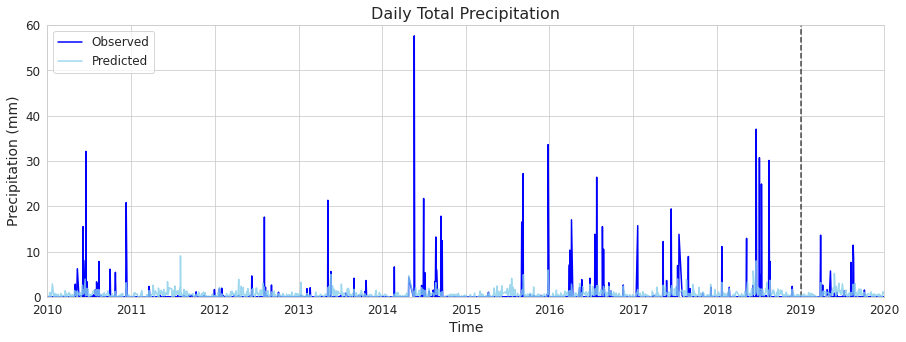

In [0]:
# Plot predicted vs. actual Precip
Precip_actual    = all_daily_data['RTOTOBS']
Precip_predicted = np.concatenate((Precip_all_pred, Precip_all_pred19))
colors = ['blue', 'skyblue']
plot_predict(pd.to_datetime(all_daily_data.index), Precip_actual, Precip_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Total Precipitation', ylabel = 'Precipitation (mm)', 
             ymin = 0, ymax = 60, outfile = 'RTOT_all_lr.png')

### Plot LR coefficients

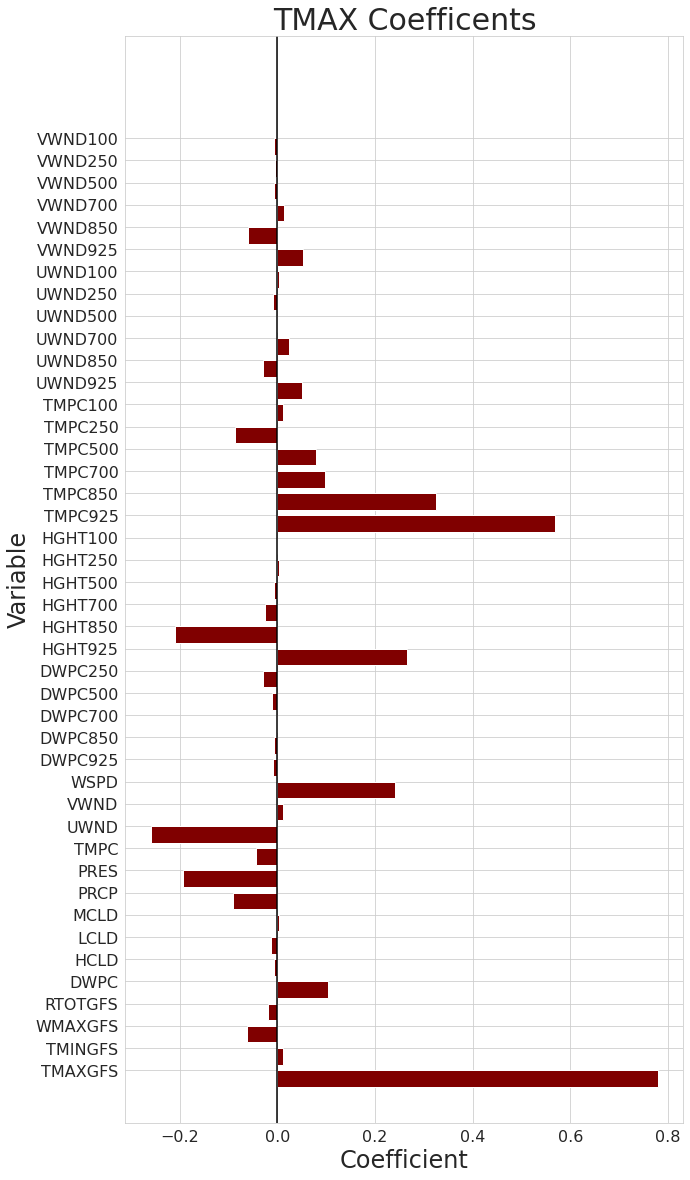

In [0]:
# Plot bar graph showing values of coefficients - Tmax
x = all_daily_data_nopcp.columns.values[3:]
y = Tmax_coef

fig, ax = plt.subplots(figsize = (10, 20))    
width = 0.75
ind = np.arange(len(y)) 
ax.barh(ind, y, width, color = "maroon")
ax.set_yticks(ind + width/2)
ax.set_yticklabels(x, minor = False)
plt.title('TMAX Coefficents', fontsize = 30)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlabel('Coefficient', fontsize = 24)
plt.ylabel('Variable', fontsize = 24)      
plt.vlines(0, -5, 50)
plt.ylim(-2, 47)
plt.savefig('tmax_coeff.png')
plt.show()

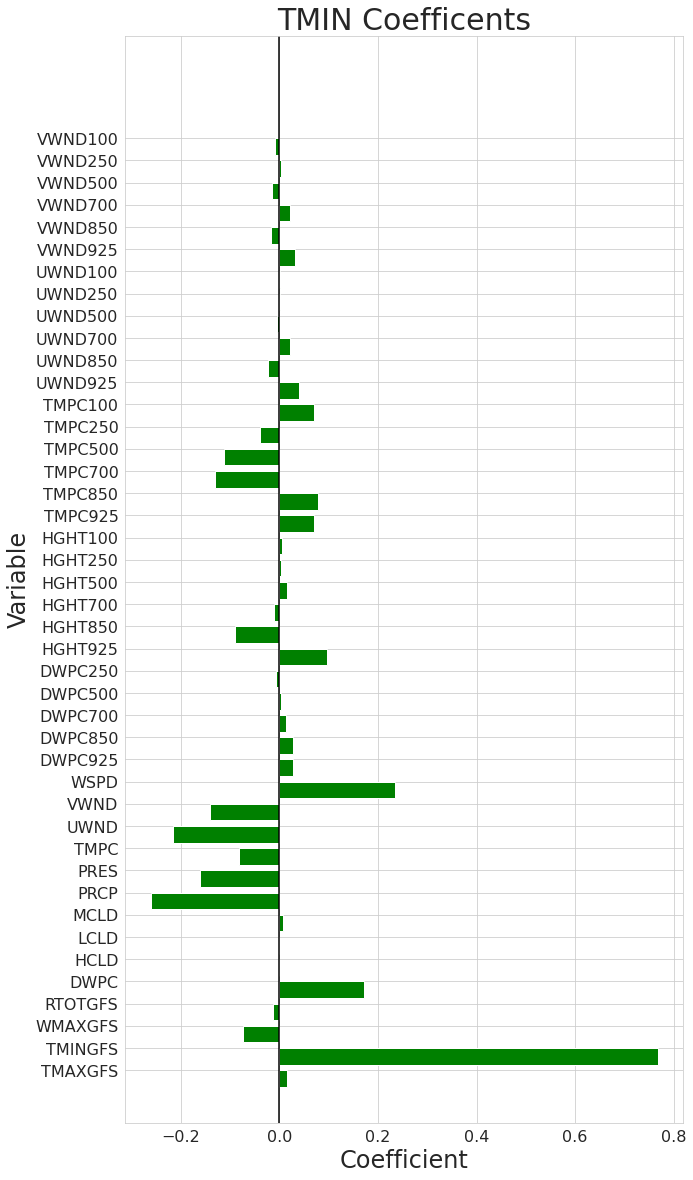

In [0]:
# Plot bar graph showing values of coefficients - Tmin
x = all_daily_data_nopcp.columns.values[3:]
y = Tmin_coef

fig, ax = plt.subplots(figsize = (10, 20))    
width = 0.75
ind = np.arange(len(y))  
ax.barh(ind, y, width, color = "green")
ax.set_yticks(ind + width/2)
ax.set_yticklabels(x, minor = False)
plt.title('TMIN Coefficents', fontsize = 30)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlabel('Coefficient', fontsize = 24)
plt.ylabel('Variable', fontsize = 24)      
plt.vlines(0, -5, 50)
plt.ylim(-2, 47)
plt.savefig('tmin_coeff.png')
plt.show()

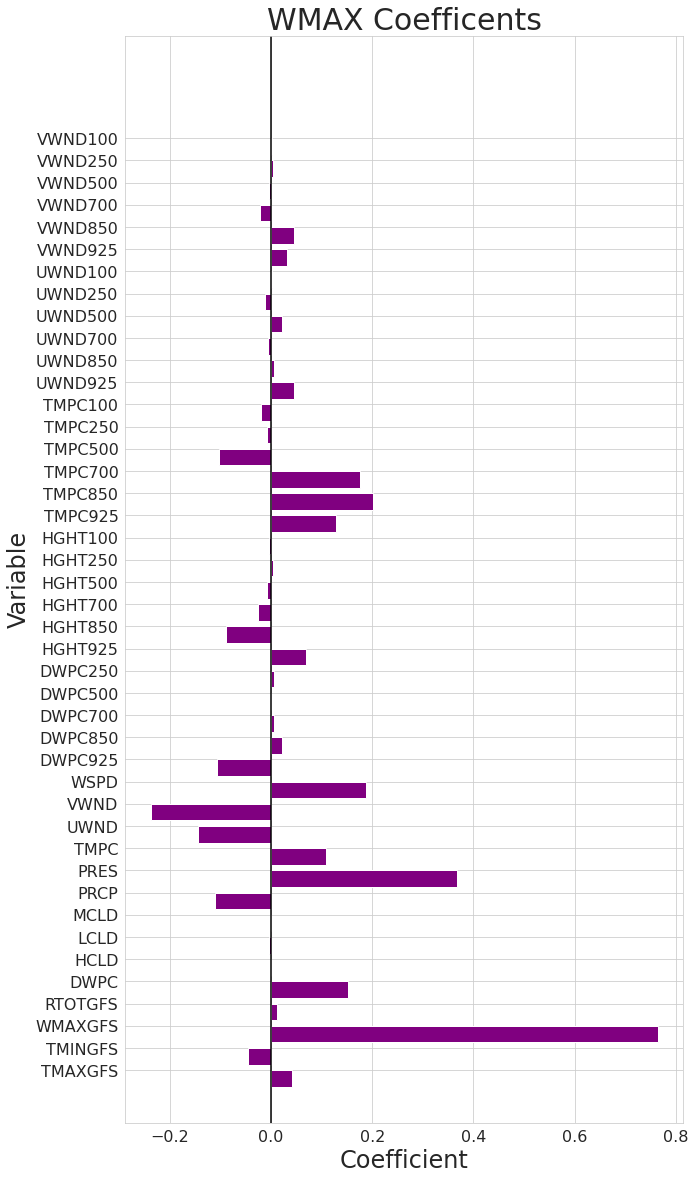

In [0]:
# Plot bar graph showing values of coefficients - Wmax
x = all_daily_data_nopcp.columns.values[3:]
y = Wmax_coef

fig, ax = plt.subplots(figsize = (10, 20))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color = "purple")
ax.set_yticks(ind + width/2)
ax.set_yticklabels(x, minor = False)
plt.title('WMAX Coefficents', fontsize = 30)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlabel('Coefficient', fontsize = 24)
plt.ylabel('Variable', fontsize = 24)      
plt.vlines(0, -5, 50)
plt.ylim(-2,47)
plt.savefig('wmax_coeff.png')
plt.show()

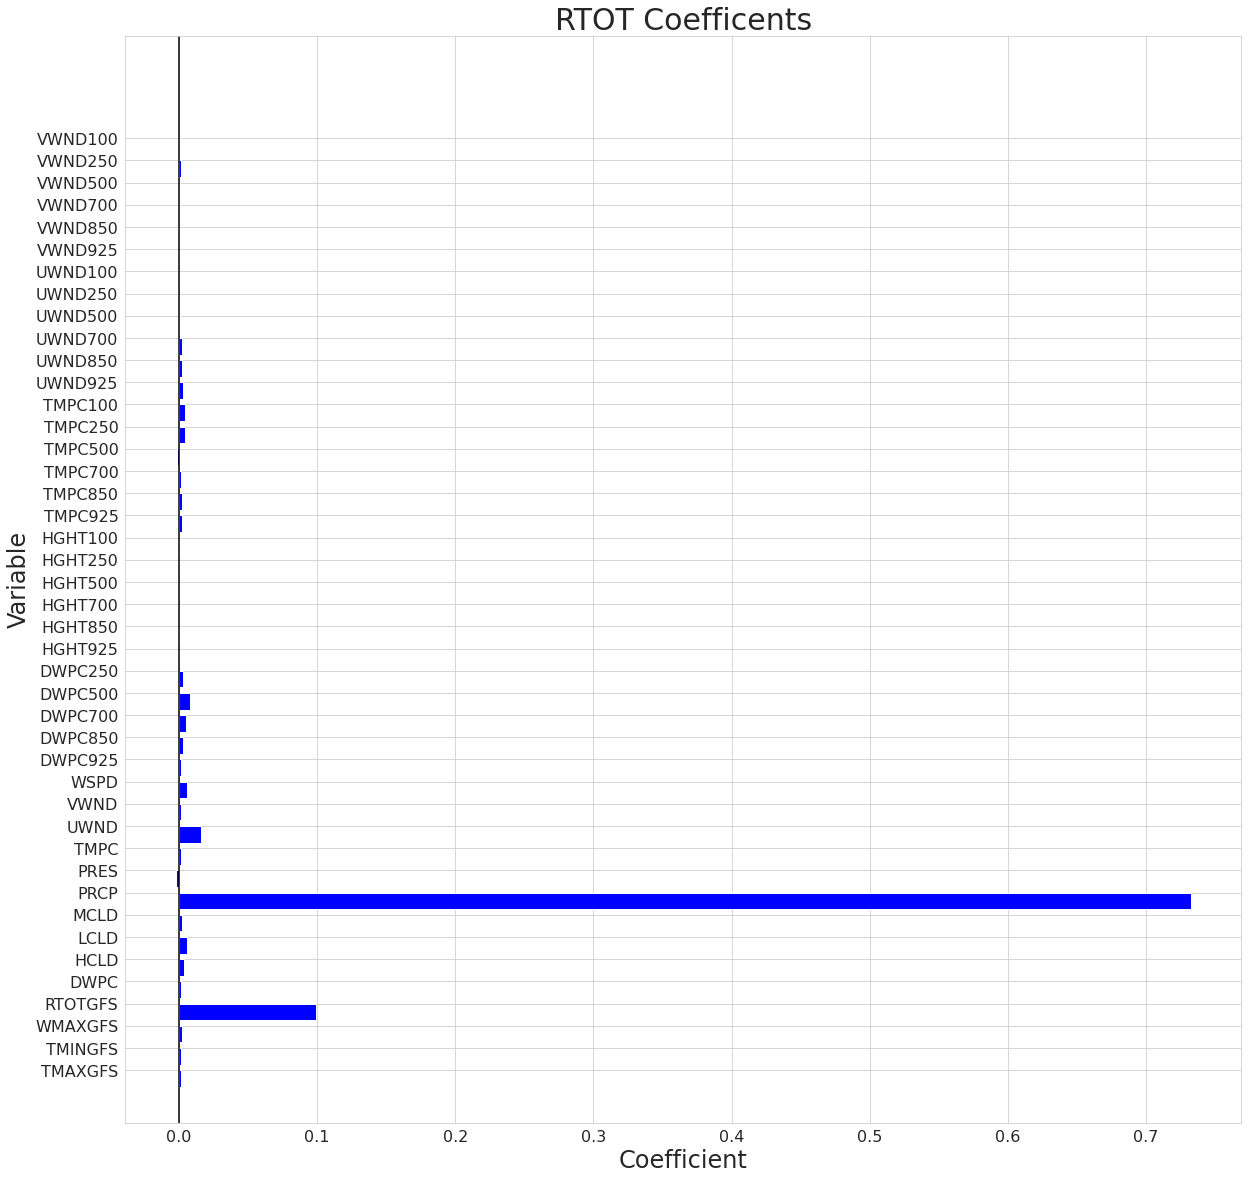

In [0]:
# Plot bar graph showing values of coefficients - Precip
x = all_daily_data.columns.values[4:]
y = Precip_coef

fig, ax = plt.subplots(figsize = (20, 20))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color = "blue")
ax.set_yticks(ind + width/2)
ax.set_yticklabels(x, minor = False)
plt.title('RTOT Coefficents', fontsize = 30)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlabel('Coefficient', fontsize = 24)
plt.ylabel('Variable', fontsize = 24)      
plt.vlines(0, -5, 50)
plt.ylim(-2, 47)
plt.savefig('precip_coeff.png')
plt.show()